In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import ImageManipulation as IM
import os
import pickle
import precisionFuncs as pF
import sys
import developmental_functions as df
import GaussAnalysisPipeline as GAP
from importlib import reload
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

### Utility functions

In [3]:
def countyield(spotLst, spotLst_an):
    """utility function to count yield for processing steps"""
    occ = df.plotOccurence(spotLst)
    occ_an = df.plotOccurence(spotLst_an)
    nG = occ * np.arange(0,occ.shape[0]).reshape([occ.shape[0],1])
    nR = occ * np.arange(0,occ.shape[1]).reshape([1,occ.shape[1]])
    npairs = occ_an * np.arange(0,occ_an.shape[0]).reshape([occ_an.shape[0],1])
    print('number of Green spots located: %i' % np.sum(nG))
    print('number of Red spots located: %i' % np.sum(nR))
    print('number of Green-Red pairs found: %i' % np.sum(npairs))

### November 18 2019

In [2]:
wdir = r'N:\Singlem\singlem19-4\November\18_CLR_rois_NV\all'
resdir = r'N:\Singlem\singlem19-4\November\18_CLR_rois_NV\analysis'
outname = os.path.join(resdir, 'CLR18Nov.spots')
options = GAP.optionsCluster(fitbg = 0, setbg = 0.2)
files = os.listdir(wdir)
CLR18Nov = df.analyseDir(options, wdir, files, Ggate = 29, Rgate = 29, Ygate = 29,
                             outname = outname, framestop = -1, ROIsize = 30, verbose = False)

analysing image no. 0
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_13-37-22.txt'
number of records is 451296


K:\vanderVoortN\FRC\Code\GaussAnalysisPipeline.py:186: RuntimeWarning: invalid value encountered in greater
  isNoJunkIstar = twoIstar > junkIstar
K:\vanderVoortN\FRC\Code\GaussAnalysisPipeline.py:191: RuntimeWarning: invalid value encountered in less
  isSignificantlyLower[i] = (twoIstar[i] + DTwoIstar < twoIstar[: i]).all()


analysing image no. 1
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_13-37-49.txt'
number of records is 440476
analysing image no. 2
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_13-38-16.txt'
number of records is 437328
analysing image no. 3
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_13-38-43.txt'
number of records is 442560
analysing image no. 4
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_13-39-10.txt'
number of records is 430556
analysing image no. 5
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_13-39-37.txt'
number of records is 437831
analysing image no. 6
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_201

KeyboardInterrupt: 

In [47]:
reload(df)

<module 'developmental_functions' from 'K:\\vanderVoortN\\FRC\\Code\\developmental_functions.py'>

In [53]:
resdir = r'N:\Singlem\singlem19-4\November\18_CLR_rois_NV\analysis'
infile = os.path.join(r'N:\Singlem\singlem19-4\November\18_CLR_rois_NV\analysis\CLR18Nov.spots')
CLR18Nov = df.loadpickle(infile)
outname = os.path.join(resdir, 'CLR18Nov_an.spots')
CLR18Nov_an = df.analyseLocLst(CLR18Nov, Ggate = 29, Rgate = 29, Ygate = 29, 
                                        verbose = False, framestop = 20, outname = outname)
outfile = os.path.join(resdir, 'CLR18Nov.pg4')
CLR18Nov_stats = df.genStats(CLR18Nov_an, outfile = outfile)

header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_13-37-22.txt'
number of records is 451296
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_13-37-49.txt'
number of records is 440476
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_13-38-16.txt'
number of records is 437328
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_13-38-43.txt'
number of records is 442560
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_13-39-10.txt'
number of records is 430556
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_13-39-37.txt'
number of records is 437831
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\al

K:\vanderVoortN\FRC\Code\developmental_functions.py:540: RuntimeWarning: invalid value encountered in double_scalars
  meantac = np.sum(tactimes * TAC) / np.sum(TAC) + TACCal / 2


number of records is 439219
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_14-07-06.txt'
number of records is 428992
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_14-07-36.txt'
number of records is 426980
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_14-08-06.txt'
number of records is 433719
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_14-08-36.txt'
number of records is 429982
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_14-09-06.txt'
number of records is 428703
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_14-09-36.txt'
number of records is 422280
header dir already exists
b'N:\\Singlem\\singlem19-4\\

In [159]:
resdir = r'N:\Singlem\singlem19-4\November\18_CLR_rois_NV\analysis'
infile = os.path.join(r'N:\Singlem\singlem19-4\November\18_CLR_rois_NV\analysis\CLR18Nov.spots')
#CLR18Nov = df.loadpickle(infile)
outname = os.path.join(resdir, 'CLR18Nov_an_gate0.spots')
CLR18Nov_an = df.analyseLocLst(CLR18Nov, Ggate = 0, Rgate = 0, Ygate = 0, 
                                        verbose = False, framestop = 20, outname = outname)
outfile = os.path.join(resdir, 'CLR18Nov_gate0.pg4')
CLR18Nov_stats = df.genStats(CLR18Nov_an, outfile = outfile)

header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_13-37-22.txt'
number of records is 451296
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_13-37-49.txt'
number of records is 440476
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_13-38-16.txt'
number of records is 437328
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_13-38-43.txt'
number of records is 442560
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_13-39-10.txt'
number of records is 430556
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_13-39-37.txt'
number of records is 437831
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\al

### Januari 16, 2020

path = os.path.join(r'N:\Singlem\singlem20-1\January\16_CLR_overnight\run1', '')
savedir = os.path.join(path, 'all')
mergePTUfiles(path, savedir)

In [5]:
wdir = r'N:\Singlem\singlem20-1\January\16_CLR_overnight\run1\all'
resdir = r'N:\Singlem\singlem20-1\January\16_CLR_overnight\analysis'
outname = os.path.join(resdir, 'CLR16Jan.spots')
options = GAP.optionsCluster(fitbg = 0, setbg = 0.2)
files = os.listdir(wdir)
CLR16Jan = df.analyseDir(options, wdir, files, Ggate = 29, Rgate = 29, Ygate = 29,
                             outname = outname, framestop = -1, ROIsize = 30, verbose = False)

analysing image no. 0
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00287604_spot_0_x_188.0_y_62.0.txt'
number of records is 100260
analysing image no. 1
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00289804_spot_0_x_-84.0_y_-155.0.txt'
number of records is 103142
analysing image no. 2
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00289804_spot_1_x_-86.0_y_-154.0.txt'
number of records is 96672
analysing image no. 3
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00292004_spot_0_x_-148.0_y_-57.0.txt'
number of records is 113524
analysing image no. 4
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00292004_spot_1_x_-157.0_y_-5

In [54]:
resdir = r'N:\Singlem\singlem20-1\January\16_CLR_overnight\analysis'
infile = os.path.join(r'N:\Singlem\singlem20-1\January\16_CLR_overnight\analysis\CLR16Jan.spots')
CLR16Jan = df.loadpickle(infile)
outname = os.path.join(resdir, 'CLR16Jan_an.spots')
CLR16Jan_an = df.analyseLocLst(CLR16Jan, Ggate = 29, Rgate = 29, Ygate = 29, 
                                        verbose = False, framestop = 20, outname = outname)
outfile = os.path.join(resdir, 'CLR16Jan.pg4')
CLR16Jan_stats = df.genStats(CLR16Jan_an, outfile = outfile)

header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00287604_spot_0_x_188.0_y_62.0.txt'
number of records is 100260
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00289804_spot_0_x_-84.0_y_-155.0.txt'
number of records is 103142
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00289804_spot_1_x_-86.0_y_-154.0.txt'
number of records is 96672
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00292004_spot_0_x_-148.0_y_-57.0.txt'
number of records is 113524
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00292004_spot_1_x_-157.0_y_-50.0.txt'
number of records is 100273
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_ove

In [160]:
resdir = r'N:\Singlem\singlem20-1\January\16_CLR_overnight\analysis'
infile = os.path.join(r'N:\Singlem\singlem20-1\January\16_CLR_overnight\analysis\CLR16Jan.spots')
CLR16Jan = df.loadpickle(infile)
outname = os.path.join(resdir, 'CLR16Jan_an_gate0.spots')
CLR16Jan_an = df.analyseLocLst(CLR16Jan, Ggate = 0, Rgate = 0, Ygate = 0, 
                                        verbose = False, framestop = 20, outname = outname)
outfile = os.path.join(resdir, 'CLR16Jan_gate0.pg4')
CLR16Jan_stats = df.genStats(CLR16Jan_an, outfile = outfile)

header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00287604_spot_0_x_188.0_y_62.0.txt'
number of records is 100260
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00289804_spot_0_x_-84.0_y_-155.0.txt'
number of records is 103142
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00289804_spot_1_x_-86.0_y_-154.0.txt'
number of records is 96672
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00292004_spot_0_x_-148.0_y_-57.0.txt'
number of records is 113524
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00292004_spot_1_x_-157.0_y_-50.0.txt'
number of records is 100273
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_ove

### Januari 21, 2020

path = os.path.join(r'N:\Singlem\singlem20-1\January\21_CLR_origami_NV\run1', '')
savedir = os.path.join(path, 'all')
mergePTUfiles(path, savedir)

In [6]:
wdir = r'N:\Singlem\singlem20-1\January\21_CLR_origami_NV\run1\all'
resdir = r'N:\Singlem\singlem20-1\January\21_CLR_origami_NV\analysis'
outname = os.path.join(resdir, 'CLR21Jan.spots')
options = df.optionsCluster(fitbg = 0, setbg = 0.2)
files = os.listdir(wdir)
CLR21Jan = df.analyseDir(options, wdir, files, Ggate = 29, Rgate = 29, Ygate = 29,
                             outname = outname, framestop = -1, ROIsize = 30)

analysing image no. 0
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\21_CLR_origami_NV\\run1\\all\\header\\allOverview_Pos_y-0.00284494_spot_0_x_149.0_y_-144.0.txt'
number of records is 97805
analysing image no. 1
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\21_CLR_origami_NV\\run1\\all\\header\\allOverview_Pos_y-0.00284494_spot_1_x_71.0_y_-127.0.txt'
number of records is 101922
analysing image no. 2
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\21_CLR_origami_NV\\run1\\all\\header\\allOverview_Pos_y-0.00284494_spot_2_x_95.0_y_-85.0.txt'
number of records is 93780
ROI touches image borders, skipping
analysing image no. 3
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\21_CLR_origami_NV\\run1\\all\\header\\allOverview_Pos_y-0.00284494_spot_3_x_-61.0_y_-53.0.txt'
number of records is 93947
analysing image no. 4
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\21_CLR_origami_NV\\run1\\all\\header\\allOverview_

In [102]:
resdir = r'N:\Singlem\singlem20-1\January\21_CLR_origami_NV\analysis'
#infile = os.path.join(resdir, 'CLR21Jan.spots')
#CLR21Jan = df.loadpickle(infile)
#outname = os.path.join(resdir, 'CLR21Jan_an.spots')
#CLR21Jan_an = df.analyseLocLst(CLR21Jan, Ggate = 29, Rgate = 29, Ygate = 29, 
#                                        verbose = False, framestop = 20, outname = outname)
outfile = os.path.join(resdir, 'CLR21Jan.pg4')
CLR21Jan_stats = df.genStats(CLR21Jan_an, outfile = outfile)

saving FRET indicators to disc for Margarita


### 10Feb Run 3 -fast scanning

In [20]:
wdir = r'N:\Singlem\singlem20-1\February\10_CLR_NV\run3_STED_fastscan'
resdir = r'N:\Singlem\singlem20-1\February\10_CLR_NV\run3_STED_fastscan\analysis'
outname = os.path.join(resdir, 'CLR10Feb_run3_fastscan.spots')

In [9]:
options = df.optionsCluster(fitbg = 0, setbg = 0.2)
files = os.listdir(wdir)
CLR10Feb_run3_fastscan = df.analyseDir(options, wdir, files, Ggate = 29, Rgate = 29, Ygate = 29,
                             outname = outname, framestop = -1, ROIsize = 30, saveplot = False)

not a .ptu file, skipping
not a .ptu file, skipping
not a .ptu file, skipping
not a .ptu file, skipping
analysing image no. 4
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run3_STED_fastscan\\header\\Overview_Pos_y-0.00678664_spot_0.txt'
number of records is 362621
analysing image no. 5
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run3_STED_fastscan\\header\\Overview_Pos_y-0.00678664_spot_1.txt'
number of records is 351960
analysing image no. 6
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run3_STED_fastscan\\header\\Overview_Pos_y-0.00678664_spot_10.txt'
number of records is 340056
analysing image no. 7
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run3_STED_fastscan\\header\\Overview_Pos_y-0.00678664_spot_11.txt'
number of records is 375717
ROI touches image borders, skipping
analysing image no. 8
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_N

In [103]:
resdir = r'N:\Singlem\singlem20-1\February\10_CLR_NV\run3_STED_fastscan\analysis'
#outname = os.path.join(resdir, 'CLR10Feb_run3_fastscan_an.spots')
#CLR10Feb_run3_fastscan_an = df.analyseLocLst(CLR10Feb_run3_fastscan, Ggate = 29, Rgate = 29, Ygate = 29, 
#                                        verbose = False, framestop = 100, outname = outname)
outfile = os.path.join(resdir, 'CLR10Feb_run3_fastscan.pg4')
Run3_stats = df.genStats(CLR10Feb_run3_fastscan_an, outfile = outfile)

saving FRET indicators to disc for Margarita


### 10 Feb Run4

indir = r'N:\Singlem\singlem20-1\February\10_CLR_NV\run4_STED'
df.simplePTUmerge(indir)

In [12]:
wdir = r'N:\Singlem\singlem20-1\February\10_CLR_NV\run4_STED\all'
resdir = r'N:\Singlem\singlem20-1\February\10_CLR_NV\run4_STED\analysis'
outname = os.path.join(resdir, 'CLR10Feb_run4.spots')

In [13]:
options = df.optionsCluster(fitbg = 0, setbg = 0.2)
files = os.listdir(wdir)
CLR10Feb_run4 = df.analyseDir(options, wdir, files, Ggate = 29, Rgate = 29, Ygate = 29,
                             outname = outname, framestop = -1, ROIsize = 30, saveplot = False)

analysing image no. 0
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.0065888_spot_0.txt'
number of records is 106191
analysing image no. 1
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.0065888_spot_1.txt'
number of records is 98268
analysing image no. 2
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.0065888_spot_10.txt'
number of records is 86858
ROI touches image borders, skipping
analysing image no. 3
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.0065888_spot_100.txt'
number of records is 94871
analysing image no. 4
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.0065888_spot_101.txt'
number of records is 95276
analysing image no. 5
header dir 

In [68]:
resdir = r'N:\Singlem\singlem20-1\February\10_CLR_NV\run4_STED\analysis'
#outname = os.path.join(resdir, 'CLR10Feb_run4_an.spots')
#CLR10Feb_run4_an = df.analyseLocLst(CLR10Feb_run4, Ggate = 29, Rgate = 29, Ygate = 29, 
#                                        verbose = False, framestop = 20, outname = outname)
outfile = os.path.join(resdir, 'CLR10Feb_run4.pg4')
Run4_stats = df.genStats(CLR10Feb_run4_an, outfile = outfile)

NameError: name 'CLR10Feb_run4_an' is not defined

# For figure

FileNotFoundError: [Errno 2] No such file or directory: 'K:\\vanderVoortN\\papers\\STED-FRET\\figOrigami\\dummy_colorbars.png'

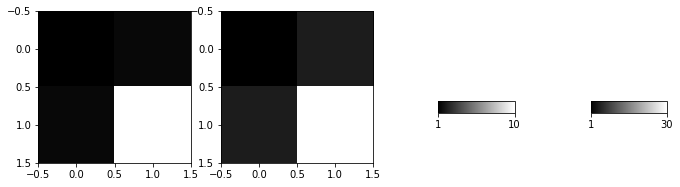

In [69]:
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[6, 3])

axins1 = inset_axes(ax1,
                   width="50%",  # width = 5% of parent_bbox width
                   height="8%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(2.1, 0., 1, 1),
                   bbox_transform=ax2.transAxes,
                   borderpad=5,
                   )

im1 = ax1.imshow([[1, 2], [2, 30]], cmap = 'gray')
fig.colorbar(im1, cax=axins1, orientation="horizontal", ticks=[1, 30])
axins1.xaxis.set_ticks_position("bottom")

axins = inset_axes(ax2,
                   width="50%",  # width = 5% of parent_bbox width
                   height="8%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.1, 0., 1, 1),
                   bbox_transform=ax2.transAxes,
                   borderpad=5,
                   )

# Controlling the placement of the inset axes is basically same as that
# of the legend.  you may want to play with the borderpad value and
# the bbox_to_anchor coordinate.

im = ax2.imshow([[1, 2], [2, 10]], cmap = 'gray')
fig.colorbar(im, cax=axins, orientation = 'horizontal', ticks=[1, 10])
plt.savefig(os.path.join(outdir, 'dummy_colorbars.png'), dpi = 300, bbox_inches = 'tight')
plt.show()

In [71]:
fname = r'N:\Singlem\singlem19-4\November\18_CLR_rois_NV\analysis\CLR18Nov_an.spots'
FRETCLR18Nov = df.loadpickle(fname)

array([28, 38, 59, 69])

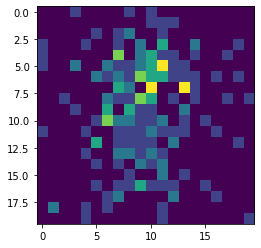

In [103]:
ROI = [30, 43, 50, 63]
plt.imshow(df.aid.crop(cherryloc['G'].bitmap, ROI))
cherryloc['G'].spotLst[0].getROI()

In [74]:
outdir = r'K:\vanderVoortN\papers\STED-FRET\figOrigami'
filterFRETCLR18Nov = df.selectSpotOccurence(FRETCLR18Nov, [2], [2])
cherryloc = filterFRETCLR18Nov[16] # other cherryloc 16
print(cherryloc['filepath'])
Gsnip = df.aid.crop(cherryloc['G'].bitmap, cherryloc['ROI'])
Rsnip = df.aid.crop(cherryloc['R'].bitmap, cherryloc['ROI'])
Ysnip = df.aid.crop(cherryloc['Y'].bitmap, cherryloc['ROI'])


plt.imshow(Gsnip, cmap = 'gray', vmax = 10)
gpos = np.array([cherryloc['G'].spotLst[0].coord, cherryloc['G'].spotLst[1].coord])
plt.plot(gpos[:,1], gpos[:,0], 'go')
plt.colorbar()
plt.savefig(os.path.join(outdir,'Gloc.png'), dpi = 300, bbox_inches = 'tight')
plt.show()

plt.imshow(Rsnip, cmap = 'gray', vmax = 10)
#dpos = np.array([cherryloc['R'].spotLst[0].coord, cherryloc['R'].spotLst[1].coord])
#print(dpos)
#plt.plot(dpos[:,1],dpos[:,0], 'go')
plt.colorbar()
plt.savefig(os.path.join(outdir,'Rloc.png'), dpi = 300, bbox_inches = 'tight')
plt.show()

plt.imshow(Ysnip, cmap = 'gray', vmax = 30)
rpos = np.array([cherryloc['Y'].spotLst[0].coord, cherryloc['Y'].spotLst[1].coord])
plt.plot(gpos[:,1],gpos[:,0], 'go')
plt.plot(rpos[:,1],rpos[:,0], 'ro')
plt.colorbar()
plt.savefig(os.path.join(outdir,'Yloc.png'), dpi = 300, bbox_inches = 'tight')
plt.show()
print('distance 1 is %.2f, distance 2 is %.2f' % 
      (np.linalg.norm(cherryloc['FRETind'][0].dist),
       np.linalg.norm(cherryloc['FRETind'][1].dist)))

N:\Singlem\singlem19-4\November\18_CLR_rois_NV\all\PQSpcm_2019-11-18_21-12-12.ptu


KeyError: 'ROI'

mean Green lifetime for C-LR is 3.3
mean Red lifetime for C-LR is 4.1
mean Yellow lifetime for C-LR is 4.0


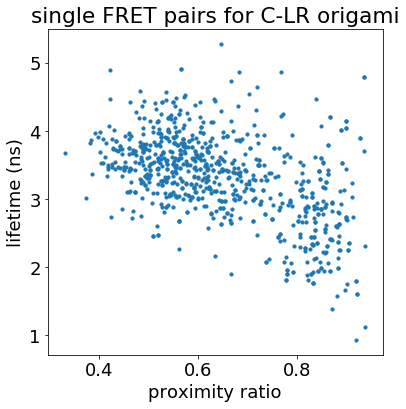

In [289]:
sample = 'C-LR'
plt.figure(figsize = (6,6))
plt.scatter(Eprox, tauG, s = 10)
mpl.rcParams.update({'font.size': 18})
plt.xlabel('proximity ratio')
plt.ylabel('lifetime (ns)')
plt.title('single FRET pairs for C-LR origami')
print('mean Green lifetime for %s is %.1f' %(sample, np.mean(tauG)))
print('mean Red lifetime for %s is %.1f' %(sample, np.mean(tauR)))
print('mean Yellow lifetime for %s is %.1f' %(sample, np.mean(tauY)))
plt.savefig(os.path.join(outdir, 'C-LR_super_super_res.png'), dpi = 300, bbox_inches = 'tight')

[-4.5209324   7.90969014]


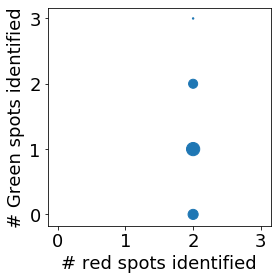

In [317]:
pxSize
A2CLR18Nov = df.selectSpotOccurence(CLR18Nov, [0,1,2,3], [2])
df.plotOccurence(A2FRETCLR18Nov)
A2dist = []
for loc in A2CLR18Nov:
    Rdist = loc['Y'].spotLst[0].coord - loc['Y'].spotLst[1].coord
    A2dist.append(Rdist)
A2dist = np.array(A2dist) * pxSize
A2dist = df.kickvector(A2dist, 120)
print(np.mean(A2dist, axis = 0))
A2dist = A2dist - np.mean(A2dist, axis = 0)

NameError: name 'minimize' is not defined

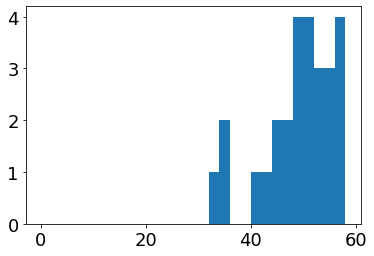

In [357]:
chiSigma = np.sqrt (Gprecision**2 + Yprecision**2 + posprecision**2)

#coords = plotSinglePair(filterCLLst, pxSize = pxSize)
counts, bin_edges, _ = plt.hist(np.linalg.norm(A2dist, axis = 1), bins = np.arange(0,60,2))

Nbins = bin_edges.shape[0] - 1
bins = np.zeros(Nbins)

for i in range(Nbins):
    bins[i] = (bin_edges[i] + bin_edges[i + 1]) / 2
fixedbounds = ((0, None), (chiSigma, chiSigma), (None, None), (None, None))
params0 = [7, 7, 500,2]
fitres_fixed = minimize(logLikelihood1D, params0, args = (ncChidistr, bins, counts), 
                  method = 'SLSQP', bounds = fixedbounds)
xgrid = np.arange(0,max(bins),0.1)
fixedfit = ncChidistr(xgrid, *fitres_fixed.x)
plt.plot(xgrid, fixedfit, label = 'MLE sigma fixed')

freebounds = ((0, None), (None, None), (None, None), (None, None))
fitres_free = minimize(logLikelihood1D, params0, args = (ncChidistr, bins, counts), 
                  method = 'SLSQP', bounds = freebounds)
freefit = ncChidistr(xgrid, *fitres_free.x)
plt.plot(xgrid, freefit, label = 'MLE sigma free')
plt.legend()
plt.show()
print('fit res if sigma fixed' + str(fitres_fixed.x))
print('fit res if sigma free' + str(fitres_free.x))

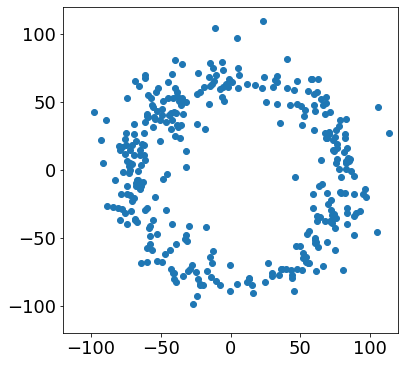

[7.47472747e+01 1.26361392e+01 6.68551265e+02 1.67002402e-01]


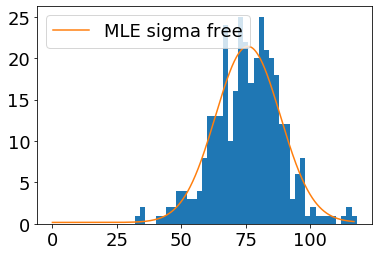

In [360]:

plt.figure(figsize = (6,6))
plt.scatter(A2dist[:,0], A2dist[:,1])
plt.xlim(-120,120)
plt.ylim(-120,120)
plt.show()


counts, bin_edges, _ = plt.hist(np.linalg.norm(A2dist, axis = 1), bins = np.arange(0,120,2))

Nbins = bin_edges.shape[0] - 1
bins = np.zeros(Nbins)
for i in range(Nbins):
    bins[i] = (bin_edges[i] + bin_edges[i + 1]) / 2
params0 = [80, 15, 100,2]
bounds = ((0, None), (chiSigma, chiSigma+0.01), (None, None), (None, None))

fitres_free = df.minimize(df.logLikelihood1D, params0, args = (df.ncChidistr, bins, counts), 
                  method = 'SLSQP')
print(fitres_free.x)
xgrid = np.arange(0,max(bins),0.1)

freefit = df.ncChidistr(xgrid, *fitres_free.x)
plt.plot(xgrid, freefit, label = 'MLE sigma free')
plt.legend()
plt.show()

# Merged C-LR

In [4]:
wdir = r'P:\STED-FRET\Origamis\data\CLR_spots'
CLR_merged = []
for file in os.listdir(wdir):
    if file.endswith('_an.spots'):
        ffile = os.path.join(wdir, file)
        print(ffile)
        CLR_merged += df.loadpickle(ffile)

P:\STED-FRET\Origamis\data\CLR_spots\CLR16Jan_an.spots
P:\STED-FRET\Origamis\data\CLR_spots\CLR18Nov_an.spots


In [100]:
outfile = r'P:\STED-FRET\Origamis\data\CLR_stats\all_cut\CLR_stats.pg4'
All_stats = df.genStats(CLR_merged, outfile)

saving FRET indicators to disc for Margarita


### HF fraction

In [5]:
plt.hist(HF_stats['stoichiometry'], bins = np.arange(0,1, 0.03))

NameError: name 'HF_stats' is not defined

5.0 in x and 0.0 in y subtracted
AIC is 815.7 for 0 peaks
AIC is 255.8 for 1 peaks
AIC is 229.5 for 2 peaks
AIC is 235.5 for 3 peaks
BIC is 819.3 for 0 peaks
BIC is 270.3 for 1 peaks
BIC is 254.9 for 2 peaks
BIC is 271.8 for 3 peaks


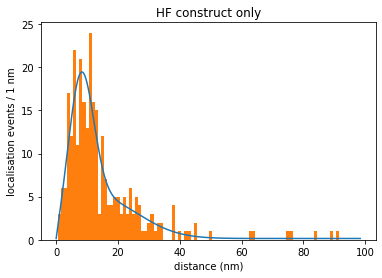

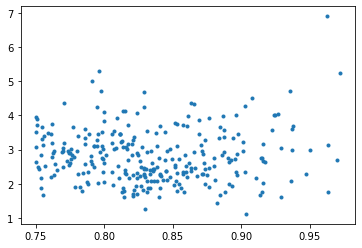

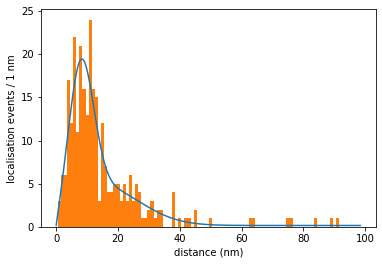

logLikelihood for custom fit is -107.74
Parameters([('bg', <Parameter 'bg', value=0 (fixed), bounds=[0:10]>), ('mu0', <Parameter 'mu0', value=7.094176920027722, bounds=[0:98.5]>), ('sig0', <Parameter 'sig0', value=4.1965465191657865, bounds=[0:inf]>), ('A0', <Parameter 'A0', value=154.28840674231094, bounds=[0:49005.0]>)])
Parameters([('bg', <Parameter 'bg', value=0 (fixed), bounds=[0:10]>), ('mu0', <Parameter 'mu0', value=10.499981354730211, bounds=[0:98.5]>), ('sig0', <Parameter 'sig0', value=13.195997597417476, bounds=[0:inf]>), ('A0', <Parameter 'A0', value=110.49083200977047, bounds=[0:49005.0]>)])


In [8]:
outdir = r'P:\STED-FRET\Origamis\data\CLR_stats\HF_cut'

HF_Lst = df.filterFRETind(CLR_merged, 'proxRatio', 0.75, 1)
HF_Lst = df.filterFRETind(HF_Lst, 'stoichiometry', 0.2, 0.8)
HF_stats = df.genStats(HF_Lst)

maxval = 100
HF_dist = np.array((HF_stats['distx'], HF_stats['disty'])).transpose()
HF_dist = df.filterVec(HF_dist, maxval = maxval, center = [5,0])
#HF_dist = df.filterVec(HF_dist, maxval = maxval)
HF_distnorm = np.linalg.norm(HF_dist, axis = 1)
outfile = os.path.join(outdir, r'CLR_distdict_HF.txt')
distDict = {}
distDict ['distx'] = HF_dist[:,0]
distDict ['disty'] = HF_dist[:,1]
distDict['distnorm'] = HF_distnorm
df.saveDict(distDict, outfile)

modelout = os.path.join(outdir, r'CLR_HF_chiFit.txt')
plotout = os.path.join(outdir, r'CLR_HF_subpopulation.png')

TACout = os.path.join(outdir, r'TAC\HF_cut.txt')
df.subensembleTAC(HF_Lst, outfile = TACout)

dist = HF_distnorm
maxbin = 100
binwidth = 1
counts, bin_edges, _ = plt.hist(dist, bins = np.arange(0, maxbin, binwidth))
plt.clf()
Nbins = bin_edges.shape[0] - 1
bins = np.zeros(Nbins)
for i in range(Nbins):
    bins[i] = (bin_edges[i] + bin_edges[i + 1]) / 2
    


fitres = df.whichChiIsBest( bins, counts, verbose = True )
df.plotdistr(HF_distnorm, bins, fit = fitres, title = 'HF construct only', 
                           modelout = modelout, plotout = plotout)
plt.plot(HF_stats['proxRatio'], HF_stats['tauG'], '.')
plt.show()

p = df.genPeakEst(2, counts, bins)
p['bg'].set(vary = True, value = 0)
p['mu0'].set(vary = True, value = 6)
p['sig0'].set(vary = True, value = 4.6)
p['A0'].set(vary = True, value = 1000)
p['mu1'].set(vary = True, value = 20)
p['sig1'].set(vary = True, value = 4.6)
p['A1'].set(vary = True, value = 1000)

fitres, *_, logLikelihood = df.fitNChidistr(p, bins, counts)
df.plotdistr(HF_distnorm, bins, fit = fitres)
print('logLikelihood for custom fit is %.2f' % logLikelihood)

outname = os.path.join(outdir, 'single_Chi_components.csv')
df.exportChiComponents(outname, bins, fitres.params)

fitres

In [250]:
reload(df)

<module 'developmental_functions' from 'C:\\Users\\voort\\vanderVoortN_mirror\\FRC\\Code\\developmental_functions.py'>

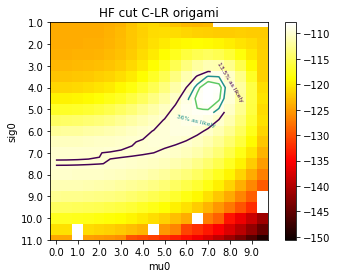

In [251]:
param_ranges={"sig0":np.arange(1, 12, 0.5),"mu0":np.arange(0, 10,0.5)}
p = df.genPeakEst(2, counts, bins)
p['bg'].set(vary = True, value = 0)
p['mu0'].set(vary = True, value = 7)
p['sig0'].set(vary = True, value = 4)
p['A0'].set(vary = True, value = 150)
p['mu1'].set(vary = True, value = 10)
p['sig1'].set(vary = True, value = 13)
p['A1'].set(vary = True, value = 110)
 
#HFsurface = df.scanLikelihoodSurface(param_ranges, p, bins, counts)
outname = r'U:\Projects\STED-FRET\Origamis\data\CLR_stats\HF_cut\Likelihood_surface.png'
df.plotLikelihoodSurface(HFsurface, param_ranges, outname = outname, title = 'HF cut C-LR origami')

In [106]:
print('mean NG is %.0f' %
      np.mean(np.array(HF_stats['AG']) * np.array(HF_stats['sigmaG'])**2 *2 * np.pi))
print('mean sigmaG is %.2f' % (np.mean(HF_stats['sigmaG'])*10))
print('mean bgG is %.2f' % np.mean(HF_stats['bgG']))
print('mean NY is %.0f' %
      np.mean(np.array(HF_stats['AY']) * np.array(HF_stats['sigmaY'])**2 *2 * np.pi))
print('mean sigmaY is %.2f' % (np.mean(HF_stats['sigmaY'])*10))
print('mean bgY is %.2f' % np.mean(HF_stats['bgY']))
df.estChiSigma(29, 25, 147, 605, 0.11, 0.58, 10, 3)

mean NG is 182
mean sigmaG is 30.50
mean bgG is 0.12
mean NY is 816
mean sigmaY is 25.58
mean bgY is 0.60
integral in variance has value -0.271200
integral in variance has value -0.264806


4.283886699064964

### NF Fraction

In [138]:
reload(df)

<module 'developmental_functions' from 'C:\\Users\\voort\\vanderVoortN_mirror\\FRC\\Code\\developmental_functions.py'>

5.0 in x and 0.0 in y subtracted


C:\Users\voort\vanderVoortN_mirror\FRC\Code\developmental_functions.py:330: RuntimeWarning: invalid value encountered in multiply
  * np.i0( r * mu / (sig**2)) + offset


fit for 3 peaks failed
AIC is 1046.7 for 0 peaks
AIC is 298.8 for 1 peaks
AIC is 273.2 for 2 peaks
BIC is 1051.3 for 0 peaks
BIC is 317.3 for 1 peaks
BIC is 305.5 for 2 peaks


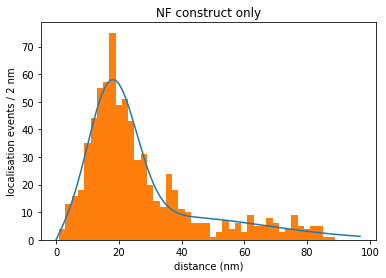

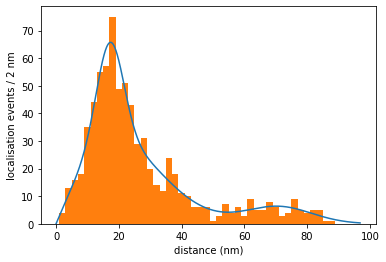

AIC for custom fit is 249.58
Parameters([('bg', <Parameter 'bg', value=0 (fixed), bounds=[0:10]>), ('mu0', <Parameter 'mu0', value=16.726605451082293, bounds=[0:97.0]>), ('sig0', <Parameter 'sig0', value=4.309390350584865, bounds=[0:inf]>), ('A0', <Parameter 'A0', value=380.3818498733164, bounds=[0:24010.0]>)])
Parameters([('bg', <Parameter 'bg', value=0 (fixed), bounds=[0:10]>), ('mu0', <Parameter 'mu0', value=0.08907159168080314, bounds=[0:97.0]>), ('sig0', <Parameter 'sig0', value=18.89413131278968, bounds=[0:inf]>), ('A0', <Parameter 'A0', value=938.9512473690388, bounds=[0:24010.0]>)])
Parameters([('bg', <Parameter 'bg', value=0 (fixed), bounds=[0:10]>), ('mu0', <Parameter 'mu0', value=69.95953485782883, bounds=[0:97.0]>), ('sig0', <Parameter 'sig0', value=10.785321459948053, bounds=[0:inf]>), ('A0', <Parameter 'A0', value=167.15713347927957, bounds=[0:24010.0]>)])


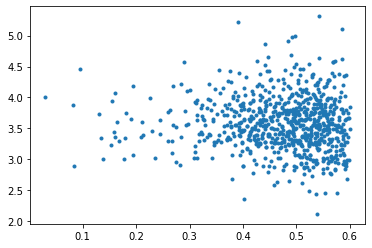

In [9]:
outdir = r'P:\STED-FRET\Origamis\data\CLR_stats\NF_cut'

NF_Lst = df.filterFRETind(CLR_merged, 'proxRatio', 0, 0.6)
NF_Lst = df.filterFRETind(NF_Lst, 'stoichiometry', 0.2, 0.8)
NF_stats = df.genStats(NF_Lst)

maxval = 100
NF_dist = np.array((NF_stats['distx'], NF_stats['disty'])).transpose()
NF_dist = df.filterVec(NF_dist, maxval = maxval, center = [5,0])
#NF_dist = df.filterVec(NF_dist, maxval = maxval)
NF_distnorm = np.linalg.norm(NF_dist, axis = 1)
outfile = os.path.join(outdir, r'CLR_distdict_NF.txt')
distDict = {}
distDict ['distx'] = NF_dist[:,0]
distDict ['disty'] = NF_dist[:,1]
distDict['distnorm'] = NF_distnorm
df.saveDict(distDict, outfile)

modelout = os.path.join(outdir, r'CLR_NF_chiFit.txt')
plotout = os.path.join(outdir, r'CLR_NF_subpopulation.png')

TACout = os.path.join(outdir, r'TAC\NF_cut.txt')
df.subensembleTAC(NF_Lst, outfile = TACout)

dist = NF_distnorm
maxbin = 100
binwidth = 2
counts, bin_edges, _ = plt.hist(dist, bins = np.arange(0, maxbin, binwidth))
plt.clf()
Nbins = bin_edges.shape[0] - 1
bins = np.zeros(Nbins)
for i in range(Nbins):
    bins[i] = (bin_edges[i] + bin_edges[i + 1]) / 2

fitres = df.whichChiIsBest( bins, counts, verbose = True )
df.plotdistr(NF_distnorm, bins, fit = fitres, title = 'NF construct only', 
                           modelout = modelout, plotout = plotout)

p = df.genPeakEst(3, counts, bins)
p['bg'].set(vary = False, value = 0)
p['mu0'].set(vary = True, value = 16)
p['sig0'].set(vary = True, value = 4)
p['A0'].set(vary = True, value = 500)
p['mu1'].set(vary = True, value = 0)
p['sig1'].set(vary = True, value = 20)
p['A1'].set(vary = True, value = 500)
p['mu2'].set(vary = True, value = 70)
p['sig2'].set(vary = True, value = 10)
p['A2'].set(vary = True, value = 500)

fitres, AIC, *_ = df.fitNChidistr(p, bins, counts)
df.plotdistr(NF_distnorm, bins, fit = fitres)
plt.plot(NF_stats['proxRatio'], NF_stats['tauG'], '.')
print('AIC for custom fit is %.2f' % AIC)

outname = os.path.join(outdir, 'single_Chi_components.csv')
df.exportChiComponents(outname, bins, fitres.params)

fitres

calculating point (2.0, 12.0)
calculating point (2.0, 17.0)
calculating point (2.5, 14.0)
calculating point (2.5, 19.0)
calculating point (3.0, 16.0)
calculating point (3.5, 13.0)
calculating point (3.5, 18.0)
calculating point (4.0, 15.0)
calculating point (4.5, 12.0)
calculating point (4.5, 17.0)
calculating point (5.0, 14.0)
calculating point (5.0, 19.0)
calculating point (5.5, 16.0)
calculating point (6.0, 13.0)
calculating point (6.0, 18.0)
calculating point (6.5, 15.0)
calculating point (7.0, 12.0)
calculating point (7.0, 17.0)
calculating point (7.5, 14.0)
calculating point (7.5, 19.0)
calculating point (8.0, 16.0)
calculating point (8.5, 13.0)
calculating point (8.5, 18.0)
calculating point (9.0, 15.0)
calculating point (9.5, 12.0)
calculating point (9.5, 17.0)


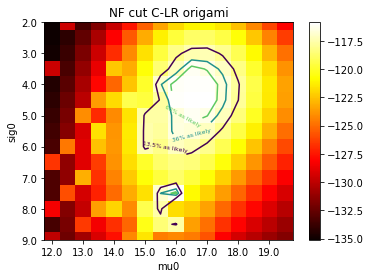

In [255]:
param_ranges={"sig0":np.arange(2,10, 0.5),"mu0":np.arange(12,20,0.5)}
p = df.genPeakEst(3, counts, bins)
p['bg'].set(vary = False, value = 0)
p['mu0'].set(vary = True, value = 16)
p['sig0'].set(vary = True, value = 4)
p['A0'].set(vary = True, value = 380)
p['mu1'].set(vary = True, value = 0)
p['sig1'].set(vary = True, value = 20)
p['A1'].set(vary = True, value = 900)
p['mu2'].set(vary = True, value = 66)
p['sig2'].set(vary = True, value = 12)
p['A2'].set(vary = True, value = 212)
 
NFsurface = df.scanLikelihoodSurface(param_ranges, p, bins, counts)
outname = r'U:\Projects\STED-FRET\Origamis\data\CLR_stats\NF_cut\Likelihood_surface.png'
df.plotLikelihoodSurface(NFsurface, param_ranges, outname = outname, title = 'NF cut C-LR origami')

In [36]:
print('mean NG is %.0f' %
      np.mean(np.array(NF_stats['AG']) * np.array(NF_stats['sigmaG'])**2 *2 * np.pi))
print('mean sigmaG is %.2f' % (np.mean(NF_stats['sigmaG'])*10))
print('mean bgG is %.2f' % np.mean(NF_stats['bgG']))
print('mean NY is %.0f' %
      np.mean(np.array(NF_stats['AY']) * np.array(NF_stats['sigmaY'])**2 *2 * np.pi))
print('mean sigmaY is %.2f' % (np.mean(NF_stats['sigmaY'])*10))
print('mean bgY is %.2f' % np.mean(NF_stats['bgY']))
Gprecision = np.sqrt(pF.findVar([0,0,32,0.12, 392], 10))
print('standard deviation of G Channel is %.2f nm' % Gprecision)
Yprecision = np.sqrt(pF.findVar([0,0,26,0.62, 724], 10))
print('standard deviation of Y Channel is %.2f nm' % Yprecision)
posprecision = 0
print('uncertainty in dye position is assumed to be %.2f nm' % posprecision)
chiSigma = np.sqrt (Gprecision**2 + Yprecision**2 + posprecision**2)
print('expected sigma of chi distribution is %.2f nm' % chiSigma)
#df.estChiSigma(29, 25, 147, 605, 0.11, 0.58, 10, 2)

mean NG is 392
mean sigmaG is 31.87
mean bgG is 0.12
mean NY is 724
mean sigmaY is 26.05
mean bgY is 0.62
integral in variance has value -0.047370
standard deviation of G Channel is 1.66 nm
integral in variance has value -0.200107
standard deviation of Y Channel is 1.09 nm
uncertainty in dye position is assumed to be 0.00 nm
expected sigma of chi distribution is 1.99 nm


## Acceptor-Acceptor Distance

In [111]:
wdir = r'P:\STED-FRET\Origamis\data\CLR_spots'
CLR_merged = []

for file in os.listdir(wdir):
    if file.endswith('.spots') and not file.endswith('_an.spots'):
        ffile = os.path.join(wdir, file)
        print(ffile)
        CLR_merged += df.loadpickle(ffile)

P:\STED-FRET\Origamis\data\CLR_spots\CLR16Jan.spots
P:\STED-FRET\Origamis\data\CLR_spots\CLR18Nov.spots


In [117]:
#the donor counts does not matter, only the acceptor count
CLR_doubleA = df.selectSpotOccurence(CLR_merged, np.arange(10), [2])

0.0 in x and 0.0 in y subtracted
AIC is 248.1 for 0 peaks
AIC is 248.1 for 1 peaks
AIC is 248.1 for 2 peaks
AIC is 248.1 for 3 peaks
BIC is 275.9 for 0 peaks
BIC is 275.9 for 1 peaks
BIC is 275.9 for 2 peaks
BIC is 275.9 for 3 peaks


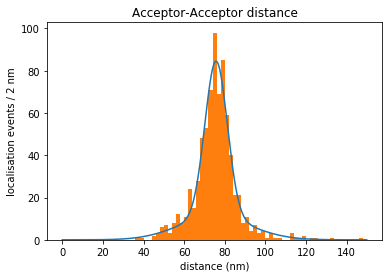

In [154]:
outdir = r'P:\STED-FRET\Origamis\data\CLR_stats\A2A_distance'
maxval = 150
#Chi fitting functions should be rewritten to better suit the current use.
#for now, this setting helps to determine starting parameters and doesn't really matter
binwidth = 2 

A2A_distx = []
A2A_disty = []
pxSize = 10
for loc in CLR_doubleA:
    A2A_distx.append( ( loc['Y'].spotLst[0].posx - loc['Y'].spotLst[1].posx ) * pxSize )
    A2A_disty.append( ( loc['Y'].spotLst[0].posy - loc['Y'].spotLst[1].posy ) * pxSize )
A2A_dist = np.array([A2A_distx, A2A_disty]).transpose()
A2A_dist = df.filterVec(A2A_dist, maxval = maxval, verbose = True, center = [0, 0])
A2A_distnorm = np.linalg.norm( A2A_dist, axis = 1)

outfile = os.path.join(outdir, r'CLR_distdict_A2A.txt')
distDict = {}
distDict ['distx'] = A2A_dist[:,0]
distDict ['disty'] = A2A_dist[:,1]
distDict['distnorm'] = A2A_distnorm
df.saveDict(distDict, outfile)

modelout = os.path.join(outdir, r'CLR_A2A_chiFit.txt')
plotout = os.path.join(outdir, r'CLR_A2A_subpopulation.png')

counts, bin_edges, _ = plt.hist(A2A_distnorm, bins = np.arange(0, maxval, binwidth))
plt.clf()
Nbins = bin_edges.shape[0] - 1
bins = np.zeros(Nbins)
for i in range(Nbins):
    bins[i] = (bin_edges[i] + bin_edges[i + 1]) / 2
    
p = df.genPeakEst(2, counts, bins)
p['bg'].set(vary = False, value = 0)
p['mu0'].set(vary = True, value = 80)
p['sig0'].set(vary = True, value = 4.6)
p['A0'].set(vary = True, value = 1000)
p['mu1'].set(vary = True, value = 80)
p['sig1'].set(vary = True, value = 15)
p['A1'].set(vary = True, value = 1000)

fitres = df.whichChiIsBest(A2A_distnorm, p = p, verbose = True, title = 'Acceptor-Acceptor distance', 
                           modelout = modelout, plotout = plotout, maxbin = maxval)
fitres

In [ ]:




fitres = df.whichChiIsBest(NF_distnorm, p = p, verbose = True, title = 'NF construct only', 
                           modelout = modelout, plotout = plotout, maxbin = maxval)
plt.plot(NF_stats['proxRatio'], NF_stats['tauG'], '.')
fitres

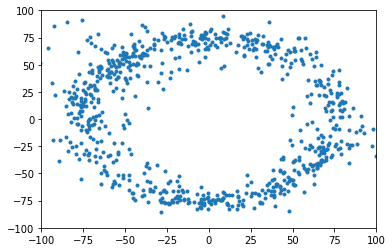

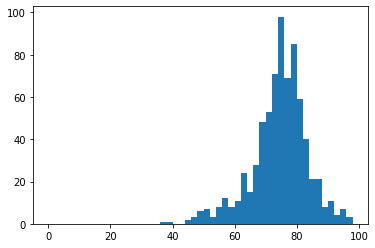

In [145]:
plt.plot(A2A_distx, A2A_disty, '.')
plt.xlim(-100, 100)
plt.ylim(-100, 100)
plt.show()
plt.hist(distnorm, bins = np.arange(0, 100, 2))
plt.show()

### Proces yields

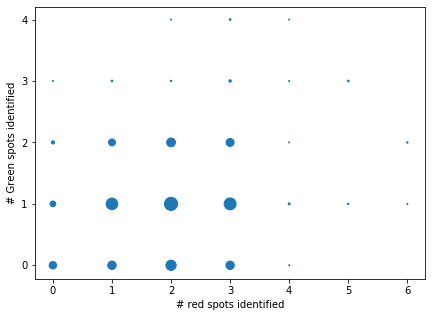

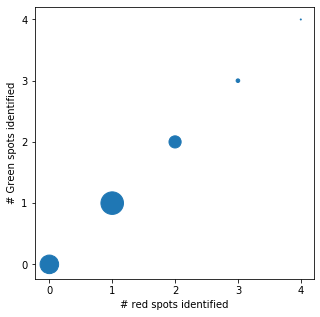

number of Green spots located: 964
number of Red spots located: 1906
number of Green-Red pairs found: 848


In [32]:
resdir = r'N:\Singlem\singlem19-4\November\18_CLR_rois_NV\analysis'
infile = os.path.join(r'N:\Singlem\singlem19-4\November\18_CLR_rois_NV\analysis\CLR18Nov.spots')
CLR18Nov = df.loadpickle(infile)
outname = os.path.join(resdir, 'CLR18Nov_an.spots')
CLR18Nov_an = df.loadpickle(outname)
countyield(CLR18Nov, CLR18Nov_an)

In [3]:
for i, val in enumerate('some'):
    print(i)

0
1
2
3


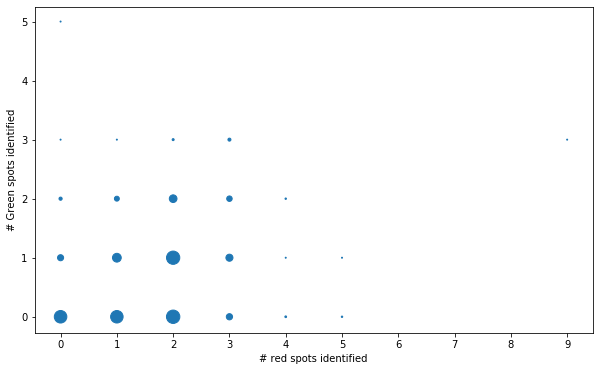

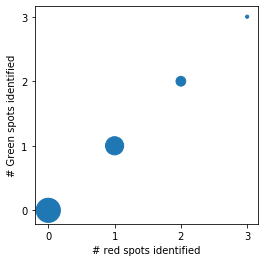

number of Green spots located: 645
number of Red spots located: 1526
number of Green-Red pairs found: 550


In [33]:
resdir = r'N:\Singlem\singlem20-1\January\16_CLR_overnight\analysis'
infile = os.path.join(r'N:\Singlem\singlem20-1\January\16_CLR_overnight\analysis\CLR16Jan.spots')
CLR16Jan = df.loadpickle(infile)
outname = os.path.join(resdir, 'CLR16Jan_an.spots')
CLR16Jan_an = df.loadpickle(outname)
countyield(CLR16Jan, CLR16Jan_an)

In [36]:
wdir = r'P:\STED-FRET\Origamis\data\CLR_spots'
CLR_merged = []
for file in os.listdir(wdir):
    if file.endswith('_an.spots'):
        ffile = os.path.join(wdir, file)
        print(ffile)
        CLR_merged += df.loadpickle(ffile)

P:\STED-FRET\Origamis\data\CLR_spots\CLR16Jan_an.spots
P:\STED-FRET\Origamis\data\CLR_spots\CLR18Nov_an.spots


In [60]:
CLR_stats = df.genStats(CLR_merged)
print('total pairs: %i' % len(CLR_stats['posxG']))
CLR_scut = df.filterStats(CLR_stats, 'stoichiometry', 0.2, 0.8)
print('pairs after stoichiometry cut: %i' % len(CLR_scut['posxG']))
CLR_NF = df.filterStats(CLR_scut, 'proxRatio', 0, 0.6)
print('NF pairs: %i' % len(CLR_NF['posxG']))
CLR_stats = df.genStats(CLR_merged)
CLR_scut = df.filterStats(CLR_stats, 'stoichiometry', 0.2, 0.8)
CLR_HF = df.filterStats(CLR_scut, 'proxRatio', 0.75, 1)
print('HF pairs: %i' % len(CLR_HF['posxG']))


total pairs: 1398
pairs after stoichiometry cut: 1353
NF pairs: 774
HF pairs: 286


In [58]:
CLR_scut

{'posxG': [60.54424616417258,
  57.236314495382004,
  56.04642061979602,
  77.81172670920519,
  70.51922532043396,
  71.25669613879491,
  71.29705976601792,
  51.47607256959289,
  63.412073166433125,
  63.924349328319124,
  54.03679606950844,
  64.75394202316937,
  76.39348286397868,
  66.20324378986433,
  57.728788118005475,
  58.87929922972172,
  57.56301721172111,
  38.09410286199781,
  37.58234291587476,
  57.38221071516687,
  42.11862606734835,
  54.86179536386226,
  53.20556361686371,
  58.90735014095529,
  47.09592500608635,
  50.115224906375694,
  44.264489000622355,
  51.083207030928534,
  52.341516507650596,
  64.19578084832753,
  49.81108321166239,
  54.157552343412036,
  63.061134947339134,
  60.31073552533893,
  61.87362335550967,
  47.29009686555493,
  50.704519887555776,
  49.959233362638805,
  58.33338856001558,
  59.03939719526829,
  55.14587023085705,
  56.24010678923137,
  51.831803675788535,
  59.9451703001325,
  63.84515128795175,
  58.179844854152044,
  59.9955965